<a href="https://colab.research.google.com/github/ChiriKamau/limaAI/blob/main/notebooks/Transfer_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

### Define Dataset Paths and Print Class Counts

This section defines the file paths for the tomato dataset, which is stored in Google Drive under the directory `/content/drive/MyDrive/Tomato_dataset/cnn_crops`. The dataset is split into ripe and green categories, each with training and validation subdirectories containing class-specific folders (e.g., 'R_ber', 'R_healthy', 'R_spots' for ripe; 'G_ber', 'G_healthy', 'G_lateblight', 'G_spots' for green). A helper function, `folder_counts`, is defined to count the number of image files in each class subfolder. This helps verify the dataset's class distribution, which is imbalanced (e.g., Ripe train: {'R_ber': 447, 'R_healthy': 768, 'R_spots': 364}, Green train: {'G_ber': 475, 'G_healthy': 2141, 'G_lateblight': 191, 'G_spots': 1537}). The counts are printed for both training and validation sets to ensure the dataset is correctly set up before training.

In [5]:


# Paths
base = '/content/drive/MyDrive/Tomato_dataset/cnn_crops'  # change if needed
ripe_train_dir = os.path.join(base, 'ripe/train')
ripe_val_dir   = os.path.join(base, 'ripe/val')
green_train_dir= os.path.join(base, 'green/train')
green_val_dir  = os.path.join(base, 'green/val')

# Quick helper to print counts
def folder_counts(p):
    out = {}
    for c in sorted(os.listdir(p)):
        cp = os.path.join(p, c)
        if os.path.isdir(cp):
            out[c] = sum([1 for f in os.listdir(cp) if os.path.isfile(os.path.join(cp, f))])
    return out

print("Ripe train counts:", folder_counts(ripe_train_dir))
print("Ripe val counts:  ", folder_counts(ripe_val_dir))
print("Green train counts:", folder_counts(green_train_dir))
print("Green val counts:  ", folder_counts(green_val_dir))



Ripe train counts: {'R_ber': 447, 'R_healthy': 768, 'R_spots': 364}
Ripe val counts:   {'R_ber': 80, 'R_healthy': 194, 'R_spots': 110}
Green train counts: {'G_ber': 475, 'G_healthy': 2141, 'G_lateblight': 191, 'G_spots': 1537}
Green val counts:   {'G_ber': 41, 'G_healthy': 481, 'G_lateblight': 41, 'G_spots': 383}


### Set Global Constants

This cell defines key constants for the model training process, tailored for the tomato dataset stored in Google Drive. `IMG_SIZE` sets the image resolution to 160x160 pixels to reduce computational load on CPU (can be increased to 224 for better accuracy with GPU). `BATCH_SIZE` is set to 12 to fit CPU memory constraints. `EPOCHS` specifies 30 training iterations, and `AUTOTUNE` optimizes data loading performance in TensorFlow. These constants will be used in data generators and model training.

In [6]:
IMG_SIZE = 160           # smaller for CPU, change to 224 if desired
BATCH_SIZE = 12          # small to fit CPU
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

### Create Data Generators for Training and Validation

This cell defines the `make_data_generators` function to load and preprocess images from the tomato dataset stored in Google Drive. It creates two `ImageDataGenerator` objects: `train_datagen` applies augmentations (rescaling, rotation, shifts, brightness changes, shear, zoom, and horizontal flips) to training images to increase diversity and help with the imbalanced dataset (e.g., fewer 'R_spots' or 'G_lateblight' samples). `val_datagen` only rescales validation images to maintain their original appearance. The function uses `flow_from_directory` to load images from the specified training and validation directories, resizing them to `IMG_SIZE` (160x160), setting the batch size to `BATCH_SIZE` (12), and configuring for categorical classification. The training data is shuffled, while validation data is not, ensuring consistent evaluation. It returns the training and validation generators for model training.

In [7]:
def make_data_generators(train_dir, val_dir, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.7,1.3),
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=(img_size, img_size),
        batch_size=batch_size, class_mode='categorical', shuffle=True
    )
    val_gen = val_datagen.flow_from_directory(
        val_dir, target_size=(img_size, img_size),
        batch_size=batch_size, class_mode='categorical', shuffle=False
    )
    return train_gen, val_gen

### Compute Class Weights for Imbalanced Dataset

This cell defines the `compute_class_weights` function to handle the imbalanced tomato dataset stored in Google Drive (e.g., Ripe train: {'R_ber': 447, 'R_healthy': 768, 'R_spots': 364}, Green train: {'G_ber': 475, 'G_healthy': 2141, 'G_lateblight': 191, 'G_spots': 1537}). The function calculates weights to prioritize underrepresented classes (e.g., 'G_lateblight' with only 191 samples) during model training, preventing the model from being biased toward majority classes like 'G_healthy' (2141 samples). It uses the training generator's `classes` attribute, which lists the class index (e.g., 0, 1, 2, ...) for each sample.

 The `compute_class_weight` function from scikit-learn, set to 'balanced' mode, computes weights as `n_samples / (n_classes * n_samples_per_class)`, where `n_samples` is the total number of samples, and `n_samples_per_class` is the count for each class. This gives higher weights to classes with fewer samples (e.g., 'G_lateblight' gets a higher weight than 'G_healthy'). The weights are returned as a dictionary mapping class indices to their weights, used in training to adjust the loss function, ensuring the model pays more attention to minority classes.

In [8]:
def compute_class_weights(generator):
    # generator.classes is the class index for each sample
    classes = generator.classes
    labels = np.unique(classes)
    cw = compute_class_weight(class_weight='balanced', classes=labels, y=classes)
    # return a dict mapping {class_index: weight}
    return {i: cw[i] for i in labels}

### Build Transfer Learning Model with MobileNetV2

This cell defines the `build_transfer_model` function to create a CNN for classifying tomato images from the dataset stored in Google Drive. It uses MobileNetV2, a lightweight model pre-trained on ImageNet, ideal for CPU training with 160x160 images.

The function takes `num_classes` (e.g., 3 for ripe, 4 for green), `img_size` (default 160), and `base_trainable` (default False) to freeze the base model initially. The model removes MobileNetV2’s top layer, applies global average pooling, and adds a custom head.

The head includes a 256-unit dense layer with ReLU, a 50% dropout to prevent overfitting, and a softmax layer for multi-class classification. It’s compiled with Adam optimizer (learning rate 0.001), categorical cross-entropy loss, and accuracy metric.

This setup leverages pre-trained features to handle the imbalanced dataset, with fine-tuning possible later by setting `base_trainable=True`.

In [9]:
def build_transfer_model(num_classes, img_size=IMG_SIZE, base_trainable=False):
    base = tf.keras.applications.MobileNetV2(
        input_shape=(img_size, img_size, 3),
        include_top=False, weights='imagenet', pooling='avg'
    )
    base.trainable = base_trainable  # freeze by default
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = base(inputs, training=False)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Train and Fine-Tune Transfer Learning Model

This cell defines the `train_with_transfer` function to train a MobileNetV2 model on the tomato dataset stored in Google Drive. It creates training and validation data generators using `make_data_generators` for the specified directories.

The function determines the number of classes from the training generator and prints class indices for verification. It computes class weights with `compute_class_weights` to handle dataset imbalance (e.g., fewer 'G_lateblight' samples).

A model is built with `build_transfer_model`, initially with a frozen base. Callbacks are set: `ModelCheckpoint` saves the best model based on validation accuracy, `EarlyStopping` halts training if validation accuracy doesn’t improve for 6 epochs, and `ReduceLROnPlateau` reduces the learning rate if validation loss stalls.

Training runs for `EPOCHS` (30) with calculated steps per epoch. After initial training, the function fine-tunes the model by unfreezing the top 20% of MobileNetV2 layers, recompiling with a lower learning rate (1e-5), and training for 10 more epochs with adjusted callbacks.

The function returns the trained model and histories for both training phases, allowing performance analysis.

### Transfer Learning Process Explained

**Transfer Learning Strategy**: This function uses a **two-phase approach** to leverage MobileNetV2's ImageNet pre-training for the imbalanced tomato dataset.

**Phase 1 - Feature Extraction**:
- MobileNetV2 base is **frozen** (`base_trainable=False`)
- Only the custom head (dense layers) is trained
- Uses higher learning rate (0.001) for 30 epochs
- Leverages pre-trained features for edges, textures, colors
- Fast training, minimal risk of destroying useful features

**Phase 2 - Fine-Tuning**:
- **Unfreezes top 20%** of MobileNetV2 layers (`fine_tune_at = 0.8`)
- Keeps bottom 80% frozen to preserve generic features
- Uses **much lower learning rate (1e-5)** to make small adjustments
- Trains for 10 more epochs
- Adapts model to tomato-specific patterns (spots, blight, ripeness)

**Why This Works**:
- **Phase 1**: Quick baseline using proven features
- **Phase 2**: Gradual specialization without overfitting
- **Imbalance Handling**: Class weights ensure minority classes (e.g., 'G_lateblight') get attention
- **CPU-Friendly**: MobileNetV2 + small batch size = efficient training

**Expected Improvement**: 5-15% accuracy boost from fine-tuning on your dataset.

In [10]:
def train_with_transfer(train_dir, val_dir, out_path, img_size=IMG_SIZE, batch_size=BATCH_SIZE, epochs=EPOCHS):
    train_gen, val_gen = make_data_generators(train_dir, val_dir, img_size, batch_size)
    num_classes = len(train_gen.class_indices)
    print("Num classes:", num_classes, "Class indices:", train_gen.class_indices)
    class_weights = compute_class_weights(train_gen)
    print("Class weights:", class_weights)

    model = build_transfer_model(num_classes, img_size, base_trainable=False)
    ckpt = ModelCheckpoint(out_path, save_best_only=True, monitor='val_accuracy', mode='max')
    es = EarlyStopping(patience=6, restore_best_weights=True, monitor='val_accuracy')
    rlp = ReduceLROnPlateau(patience=3, factor=0.5, monitor='val_loss')

    steps_per_epoch = max(1, train_gen.samples // batch_size)
    val_steps = max(1, val_gen.samples // batch_size)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=[ckpt, es, rlp],
        steps_per_epoch=steps_per_epoch,
        validation_steps=val_steps,
        verbose=1
    )

    # Optionally fine-tune: unfreeze last few layers and train with low LR
    base = model.layers[1]  # MobileNetV2 base if you used the builder above - check model.layers
    base.trainable = True
    # freeze all except top N layers
    fine_tune_at = int(len(base.layers) * 0.8)
    for layer in base.layers[:fine_tune_at]:
        layer.trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    ft_history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        class_weight=class_weights,
        callbacks=[EarlyStopping(patience=4, restore_best_weights=True), ReduceLROnPlateau(patience=2)],
        steps_per_epoch=steps_per_epoch,
        validation_steps=val_steps,
        verbose=1
    )
    return model, history, ft_history

### Train Green Tomato Model

This cell trains a MobileNetV2 model for the green tomato dataset in Google Drive. It calls `train_with_transfer` with the green training and validation directories, saving the best model to the specified path. The function handles data loading, class weights, and two-phase training for green model which has 3 classes ( 'G_ber', 'G_lateblight', 'G.spots', 'G.healthy').

In [11]:
# Cell C: run training

green_model_path = '/content/drive/MyDrive/Tomato_dataset/models/green_mobilenet(v2).keras'


# Green
_ = train_with_transfer(green_train_dir, green_val_dir, green_model_path)


Found 4344 images belonging to 4 classes.
Found 946 images belonging to 4 classes.
Num classes: 4 Class indices: {'G_ber': 0, 'G_healthy': 1, 'G_lateblight': 2, 'G_spots': 3}
Class weights: {np.int32(0): np.float64(2.2863157894736843), np.int32(1): np.float64(0.507239607659972), np.int32(2): np.float64(5.68586387434555), np.int32(3): np.float64(0.7065712426805465)}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 1293s 4s/step - accuracy: 0.4382 - loss: 1.6314 - val_accuracy: 0.5940 - val_loss: 1.0225 - learning_rate: 0.0010
Epoch 2/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 162s 447ms/step - accuracy: 0.5877 - loss: 0.9415 - val_accuracy: 0.5395 - val_loss: 1.0914 - learning_rate: 0.0010
Epoch 3/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 164s 452ms/step - accuracy: 0.6001 - loss: 0.8882 - val_accuracy: 0.5951 - val_loss: 0.9667 - learning_rate: 0.0010
Epoch 4/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 201s 556ms/step - accuracy: 0.6451 - loss: 0.8117 - val_accuracy: 0.6795 - val_loss: 0.8760 - learning_rate: 0.0010
Epoch 5/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 202s 558ms/step - accuracy: 0.6267 - loss: 0.8106 - val_accuracy: 0.6752 - val_loss: 0.8484 - learning_rate: 0.0010
Epoch 6/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 200s 554ms/step - accuracy: 0.6304 - loss: 0.8049 - val_accuracy: 0.5620 - val_loss: 1.0733 - learning_rate: 0.0010
Epoch 7/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 168s 464ms/step - accuracy

### Train Ripe Tomato Model

This cell trains a MobileNetV2 model for the ripe tomato dataset in Google Drive. It calls `train_with_transfer` with the ripe training and validation directories, saving the best model to the specified path. The function manages data loading, class weights, and two-phase training for ripe model which have 3 classes ( 'R_ber', 'R_healthy', 'R.spots').

In [12]:
ripe_model_path = '/content/drive/MyDrive/Tomato_dataset/models/ripe_mobilenet(v2).keras'   # prefer .keras
# Ripe
_ = train_with_transfer(ripe_train_dir, ripe_val_dir, ripe_model_path)


Found 1579 images belonging to 3 classes.
Found 384 images belonging to 3 classes.
Num classes: 3 Class indices: {'R_ber': 0, 'R_healthy': 1, 'R_spots': 2}
Class weights: {np.int32(0): np.float64(1.1774794929157346), np.int32(1): np.float64(0.6853298611111112), np.int32(2): np.float64(1.445970695970696)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.5284 - loss: 1.2710 - val_accuracy: 0.5182 - val_loss: 0.9354 - learning_rate: 0.0010
Epoch 2/30
  1/131 ━━━━━━━━━━━━━━━━━━━━ 26s 204ms/step - accuracy: 0.5000 - loss: 0.9452

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.5000 - loss: 0.9452 - val_accuracy: 0.5234 - val_loss: 0.9266 - learning_rate: 0.0010
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 468ms/step - accuracy: 0.6534 - loss: 0.7413 - val_accuracy: 0.5521 - val_loss: 0.9390 - learning_rate: 0.0010
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.7500 - loss: 0.4382 - val_accuracy: 0.5521 - val_loss: 0.9413 - learning_rate: 0.0010
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 468ms/step - accuracy: 0.6920 - loss: 0.6892 - val_accuracy: 0.6016 - val_loss: 0.8386 - learning_rate: 0.0010
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.5833 - loss: 0.6760 - val_accuracy: 0.5703 - val_loss: 0.8437 - learning_rate: 0.0010
Epoch 7/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 461ms/step - accuracy: 0.6977 - loss: 0.6575 - val_accuracy: 0.5651 - val_loss: 0.8823 - learning_rate: 0.0010
Epoch 8/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8333 - loss: 0.824

🔹 Loading model from: /content/drive/MyDrive/Tomato_dataset/models/green_mobilenet(v2).keras
Found 946 images belonging to 4 classes.
🔹 Evaluating 946 images...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 814ms/step

✅ Accuracy: 0.6755
✅ F1-score: 0.6823

📊 Classification Report:
              precision    recall  f1-score   support

       G_ber       0.23      0.27      0.25        41
   G_healthy       0.73      0.77      0.75       481
G_lateblight       0.32      0.71      0.44        41
     G_spots       0.76      0.60      0.67       383

    accuracy                           0.68       946
   macro avg       0.51      0.59      0.53       946
weighted avg       0.70      0.68      0.68       946



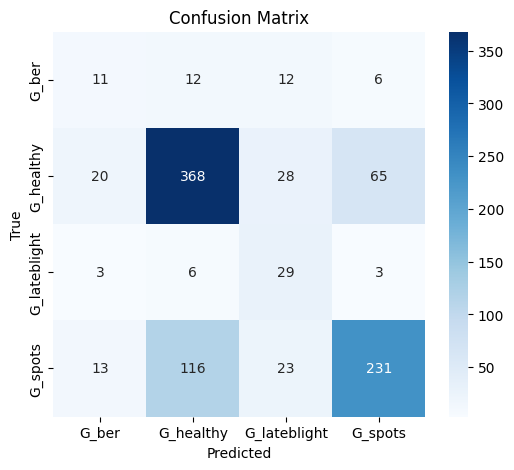

🔹 Loading model from: /content/drive/MyDrive/Tomato_dataset/models/ripe_mobilenet(v2).keras
Found 384 images belonging to 3 classes.
🔹 Evaluating 384 images...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step

✅ Accuracy: 0.6016
✅ F1-score: 0.6027

📊 Classification Report:
              precision    recall  f1-score   support

       R_ber       0.62      0.62      0.62        80
   R_healthy       0.66      0.64      0.65       194
     R_spots       0.49      0.52      0.50       110

    accuracy                           0.60       384
   macro avg       0.59      0.59      0.59       384
weighted avg       0.60      0.60      0.60       384



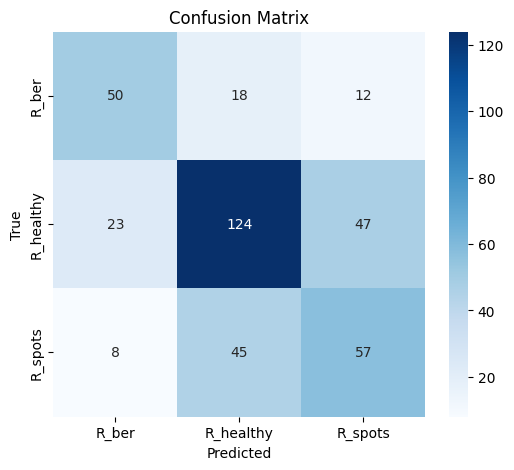

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def evaluate_model(model_path, data_dir, img_size=(224, 224), batch_size=32):
    print(f"🔹 Loading model from: {model_path}")
    model = load_model(model_path)

    # Load validation data
    datagen = ImageDataGenerator(rescale=1./255)
    val_gen = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    print(f"🔹 Evaluating {val_gen.samples} images...")
    preds = model.predict(val_gen)
    y_true = val_gen.classes
    y_pred = np.argmax(preds, axis=1)
    class_names = list(val_gen.class_indices.keys())

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n✅ Accuracy: {acc:.4f}")
    print(f"✅ F1-score: {f1:.4f}\n")

    print("📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# 🧠 Example usage:
evaluate_model(
    "/content/drive/MyDrive/Tomato_dataset/models/green_mobilenet(v2).keras",
    "/content/drive/MyDrive/Tomato_dataset/cnn_crops/green/val",
    img_size=(160, 160)   # ✅ Match model training size
)
evaluate_model(
    "/content/drive/MyDrive/Tomato_dataset/models/ripe_mobilenet(v2).keras",
    "/content/drive/MyDrive/Tomato_dataset/cnn_crops/ripe/val",
    img_size=(160, 160)   # ✅ Match model training size
)

